### Notebook to apply the trained restoration model to the experimental nanoparticles data sets

*The data set consists of 2D projections from experimental nanoparticles (-60°:2°:+60°). Two realistic additional degraded scenarios are also compared.*
- -60°:2°:+60°
- -60°:10°:+60°
- -30°:2°:+30°

In [27]:
import sys
sys.path.insert(0, '../../Src')
from model import *
from radon import *
from dip import *
from utils import *

import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
import torch
from pathlib import Path

plt.gray()

dtype = torch.cuda.FloatTensor
DEVICE = 'cuda'

<Figure size 640x480 with 0 Axes>

#### Load the experimental data


In [43]:
IDX = 159 
projections = imread('../../Data/Experimental/HAADF_slice_ali_contrast.tif')
projections = projections.reshape(62, 512, 4, 512, 4).mean(2).mean(-1)
projections = normalize(projections)

sinogram = torch.from_numpy(projections[:,IDX,:]).type(dtype)

THETA = np.arange(27., 151., 2.)
IMG_SIZE = sinogram.shape[1]

# 1, 2 or 3 corresponding to acquisition range -60:2:+60, -60:10:+60 and -30:2:+30 respectively
ACQUISITION_CASE = 2
SELECT = {
    1: [sinogram, THETA],
    2: [sinogram[::5,:], THETA[::5]],
    3: [sinogram[15:-15,:], THETA[15:-15]],
}

degraded_sino = SELECT[ACQUISITION_CASE][0]
degraded_THETA = SELECT[ACQUISITION_CASE][1]

radon_op = Radon2D(angle=np.deg2rad(THETA), size=IMG_SIZE)
sirt_reco = radon_op.backward_sirt_ts(sinogram)
sirt_reco = normalize(sirt_reco)

#### Load and apply the trained network to the SIRT degraed reconstruction


In [44]:
ud_filters, skip_filters = [32,64,128], [8,16,32]
n_scale = len(ud_filters)
model = model_unet(input_shape=1,
            down_filters=ud_filters, up_filters=ud_filters, skip_filters=skip_filters,
            down_kernels=[3]*len(ud_filters), up_kernels=[3]*len(ud_filters), skip_kernels=[1]*len(ud_filters),
            up_mode='bilinear', down_mode='stride', pad_mode='reflect'
           ).to('cuda').type(dtype)

model.load_state_dict(torch.load(f"../../Temp_out/model_trained_{ACQUISITION_CASE}.pth"))

/tmp/ipykernel_2929300/3537282608.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"../../Temp_out/model_trained_{ACQUISITION_CASE}.pth"

<All keys matched successfully>

In [45]:
net_input = rearrange(sirt_reco, '1 x y -> 1 1 x y')
out_model = model(net_input)

Text(0.5, 1.0, 'U-Net restoration from SIRT')

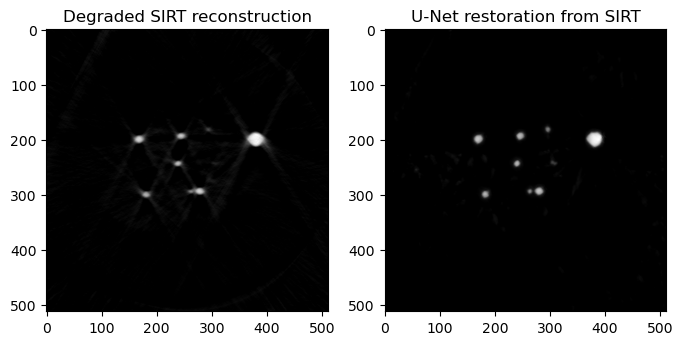

In [46]:
fig, ((ax0, ax1)) = plt.subplots(1, 2, figsize = (8,5))
ax0.imshow(simplify(sirt_reco))
ax0.set_title('Degraded SIRT reconstruction')
ax1.imshow(simplify(out_model))
ax1.set_title('U-Net restoration from SIRT')

#### Save the restored reconstruction

In [47]:
OUT_PATH = Path("../../Temp_out")
if not OUT_PATH.is_dir():
    OUT_PATH.mkdir()

imsave(f'{OUT_PATH}/out_exp_supervised_{ACQUISITION_CASE}.tif', simplify(out_model))